In [1]:
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sn
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn as nn
import os
import json

In [2]:
class_names = {
    0: 'badminton',
    1: 'baseball',
    2: 'basketball',
    3: 'boxing',
    4: 'cricket',
    5: 'football',
    6: 'gymnastics',
    7: 'hockey',
    8: 'swimming',
    9: 'table_tennis',
    10: 'tennis',
    11: 'volleyball',
    12: 'weight_lifting',
    13: 'wrestling',
    14: 'wwe'
}

classes = [class_name for class_name in class_names.values()]

In [3]:

models = ['resnet', 'alexnet', 'efficientnet_b7', 'vgg_19']
paths = [f'./models/{model_name}.pt' for model_name in models]
loaded_models = {}

for path, model_name in zip(paths, models):
    try:
        model = torch.jit.load(path)
        loaded_models[model_name] = model
    except Exception:
        print(f'model {model_name} is not available')

In [4]:
preprocess_image = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225])
])

In [5]:
df = pd.read_csv("./data/data.csv") # path to images
y = torch.as_tensor(df['label'].values)
image_paths = df['path']
images = []

for path in image_paths:
    try:
        img = Image.open(path)
        images.append(preprocess_image(img.convert('RGB')))
    except Exception as e:
        pass

X = torch.stack(images)
print(X.shape)

torch.Size([10303, 3, 224, 224])


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def get_batch(X, y, batch_size, iteration):
    start = batch_size * iteration
    end = (batch_size) * (iteration + 1)
    if end > X.shape[0]:
        end = X.shape[0]
    return X[start:end, :, :, :], y[start:end]

In [9]:
models_accuracies = {}
with open('models_accuracies.txt', 'r') as file:
    models_accuracies = json.load(file)

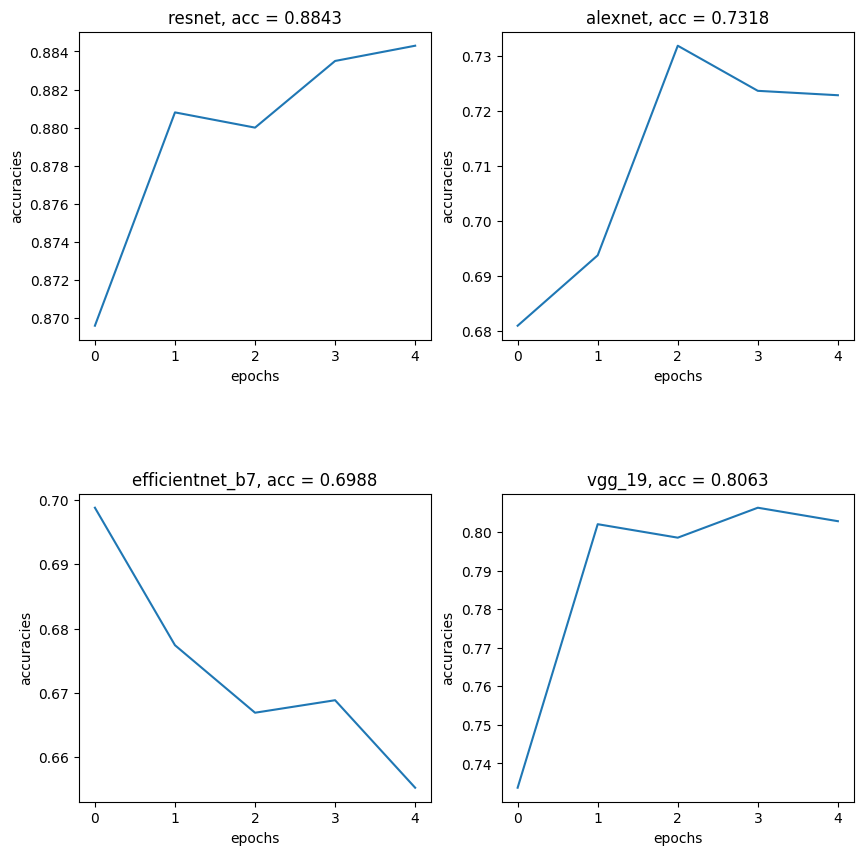

In [30]:
fig, ax = plt.subplots(2, len(models_accuracies)//2, figsize=(10, 10))
plt.subplots_adjust(hspace=0.5)

models_best_accuracy = {}

for index, (model_name, model_accuracies) in enumerate(models_accuracies.items()):
    best_epoch, best_acc = max([(epoch, value['test accuracy']) for epoch, value in model_accuracies.items()], key= lambda x:x[-1])
    models_best_accuracy[model_name] = best_acc
    ax[index//2, index%2].plot([key for key in model_accuracies.keys()], [value['test accuracy'] for value in model_accuracies.values()])
    ax[index//2, index%2].set_title(f'{model_name}, acc = {round(best_acc,4)}')
    ax[index//2, index%2].set_xlabel('epochs')
    ax[index//2, index%2].set_ylabel('accuracies')

batch test : 0/206
batch test : 66/206
batch test : 132/206
batch test : 198/206


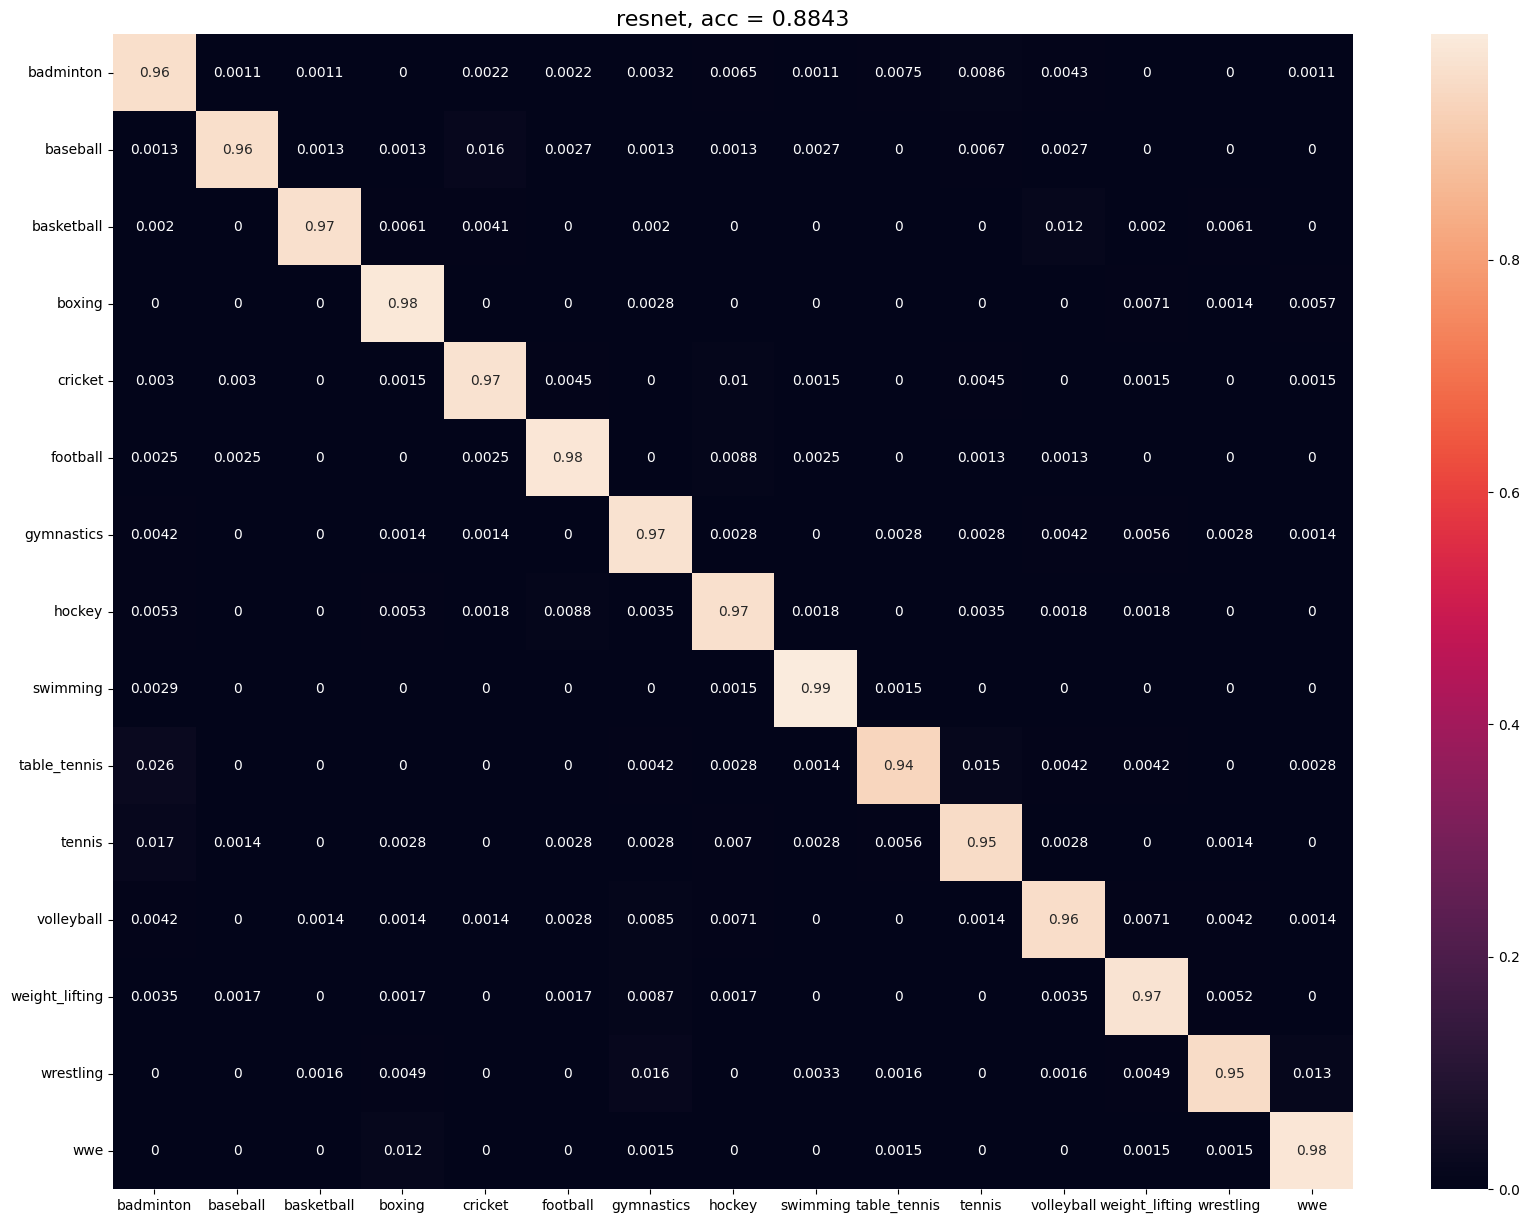

batch test : 0/206
batch test : 66/206
batch test : 132/206
batch test : 198/206


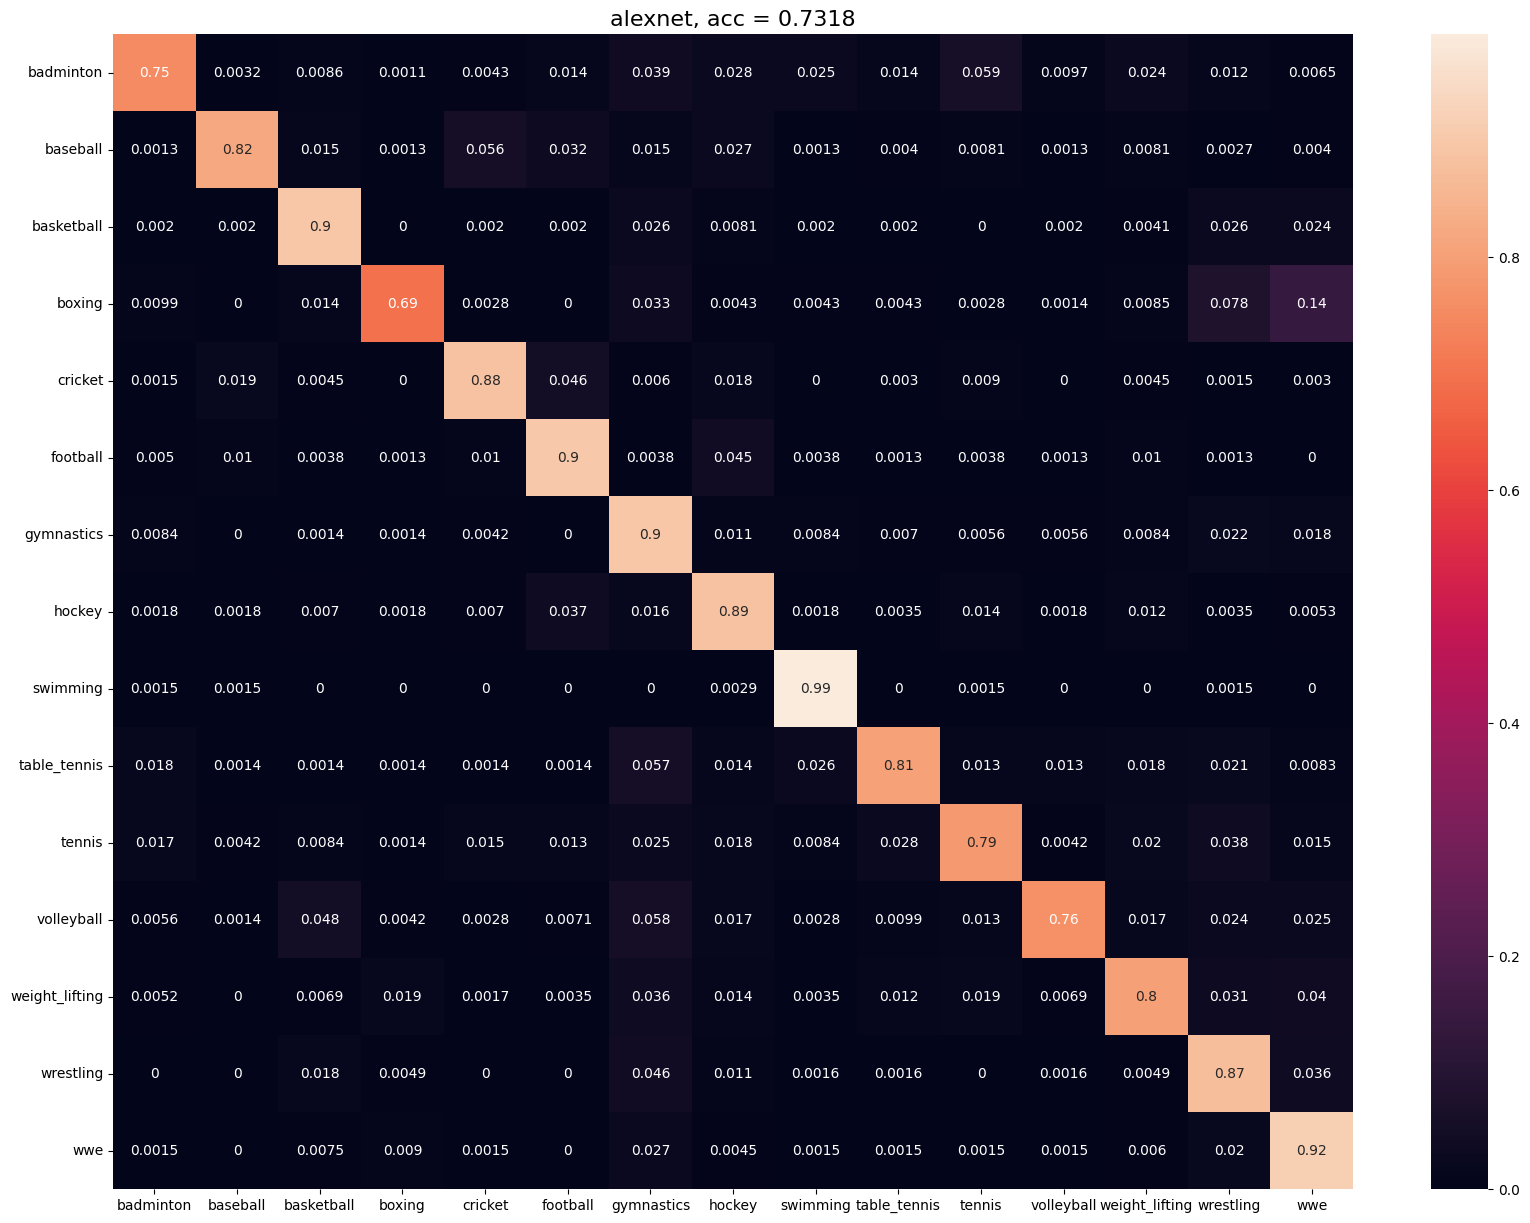

batch test : 0/206
batch test : 66/206
batch test : 132/206
batch test : 198/206


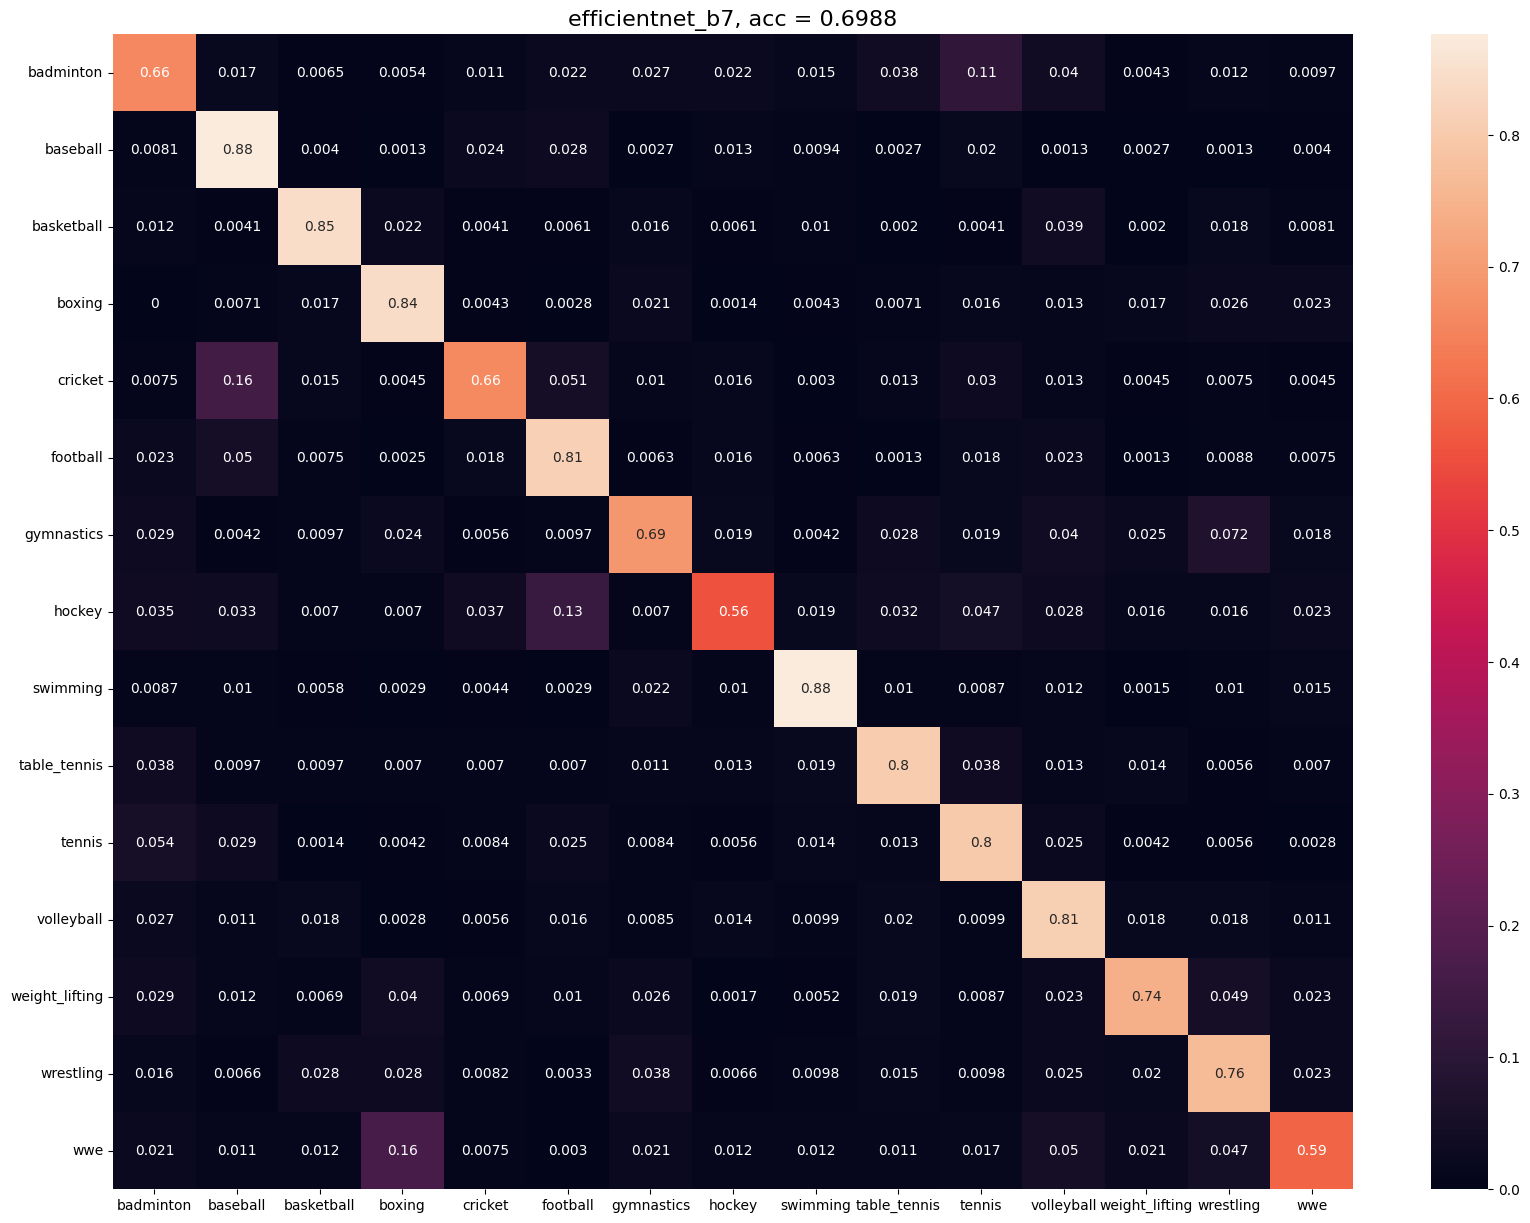

batch test : 0/206
batch test : 66/206
batch test : 132/206
batch test : 198/206


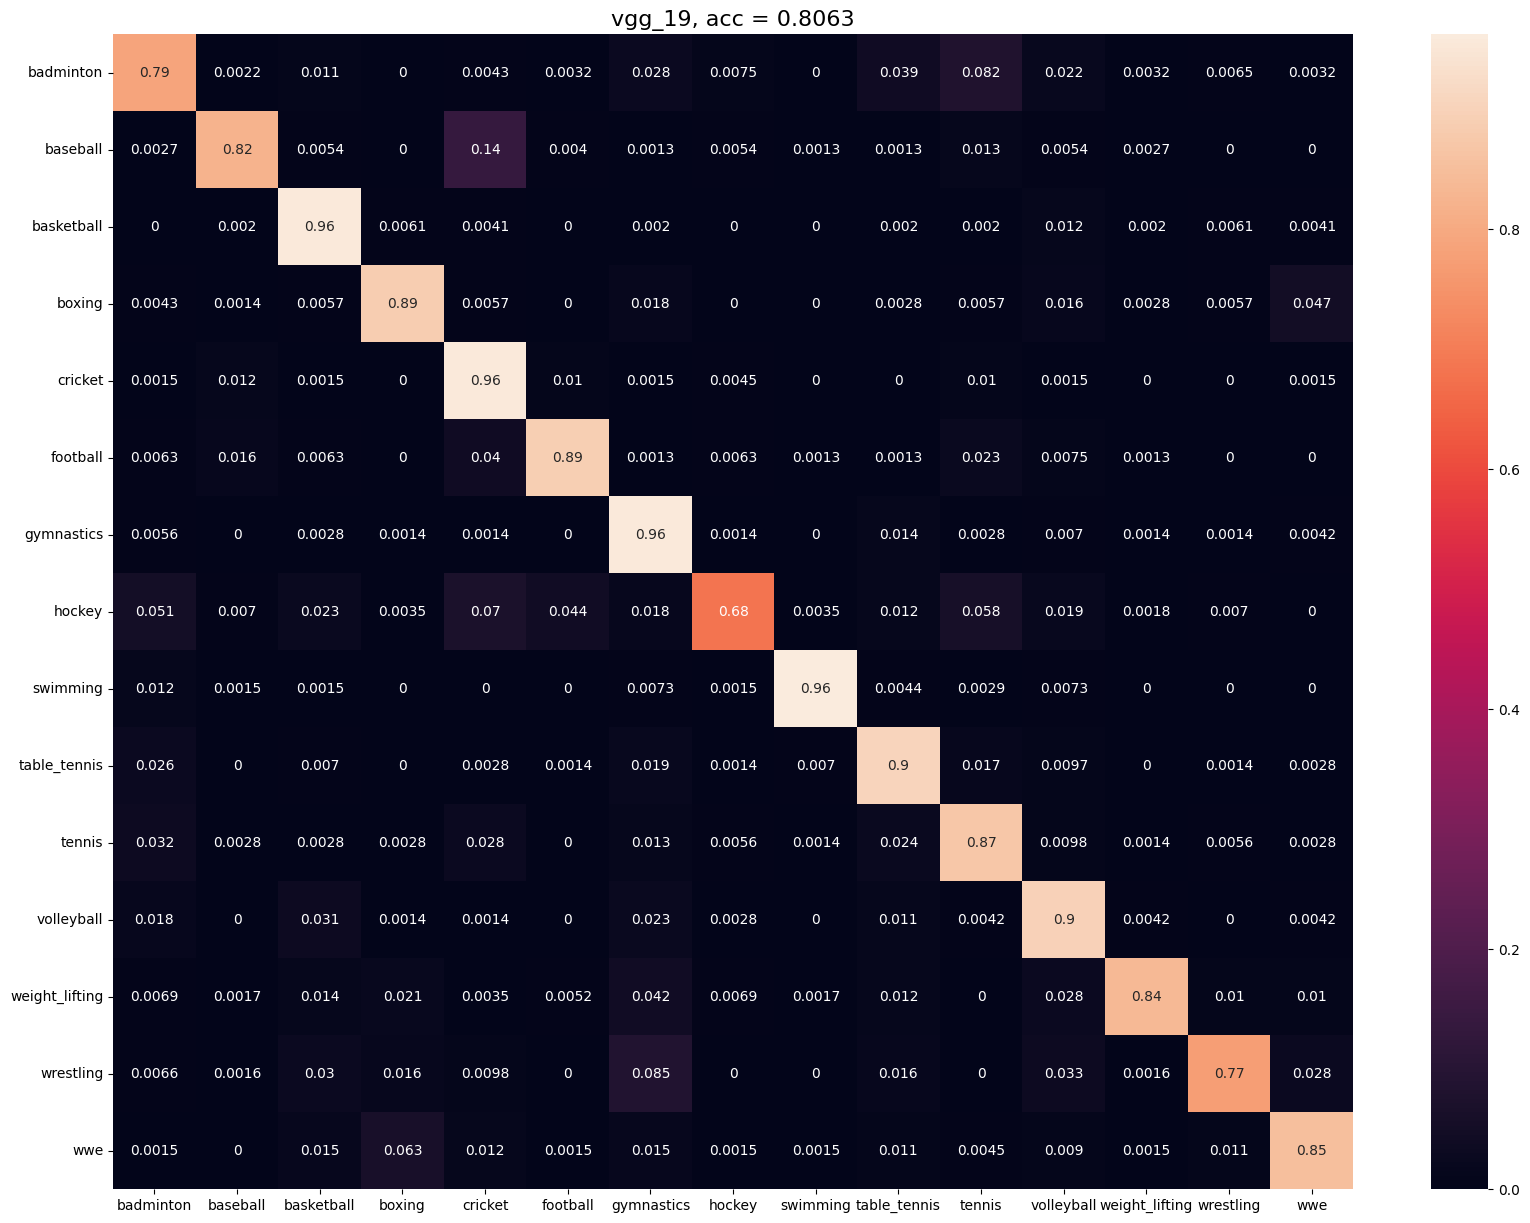

In [31]:
batch_size = 50

for model_name, model in loaded_models.items():
    model.eval()
    batch_test_count = (X.shape[0] // batch_size) + 1

    y_pred = []
    y_true = []

    for num_batch in range(batch_test_count):
        if (num_batch % 66 == 0):
            print(f'batch test : {num_batch}/{batch_test_count - 1}')
        inputs, labels = get_batch(X, y, batch_size, num_batch)
        inputs = inputs.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.numpy())
        labels = labels.numpy()
        y_true.extend(labels) # Save Truth
        
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix / cf_matrix.astype(float).sum(axis=1, keepdims=True), index = [i for i in classes],
                        columns = [i for i in classes])
    plt.figure(figsize = (20,15))
    sn.heatmap(df_cm, annot=True)
    plt.title(f'{model_name}, acc = {round(models_best_accuracy[model_name],4)}', fontsize = 16)
    plt.show()

In [27]:
def imshow(inp, axis):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    axis.imshow(inp)

def visualize_model(X, y, model, num_images=12, suptitle=None):
    "display several images predictions and truth for all of them"
    nb_row = num_images // 4 if num_images % 4 == 0 else (num_images // 4) + 1
    fig, ax = plt.subplots(nb_row, 4, sharex='col', sharey='row', figsize=(10, 10*(nb_row/4)))
    plt.subplots_adjust(hspace=0.5)

    if suptitle is not None:
        fig.suptitle(suptitle, fontsize = 16)

    with torch.no_grad():
        inputs, labels = X, y
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        for row_index in range(num_images):
            imshow(inputs[row_index], ax[row_index//4, row_index % 4])
            ax[row_index//4, row_index % 4].axis('off')
            title = f'predicted: {class_names[preds[row_index].item()]}\ntruth: {class_names[labels[row_index].item()]}'
            ax[row_index//4, row_index % 4].set_title(title)
    plt.show()

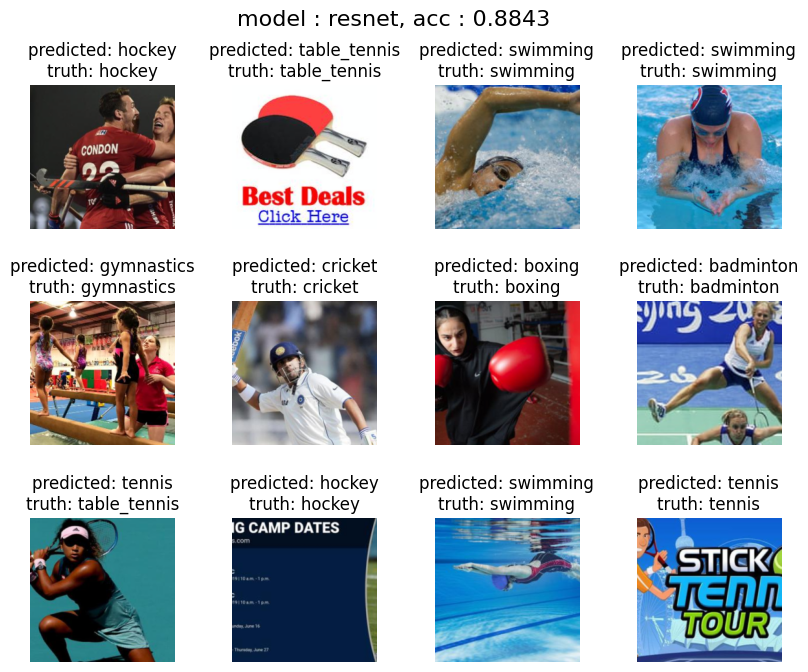

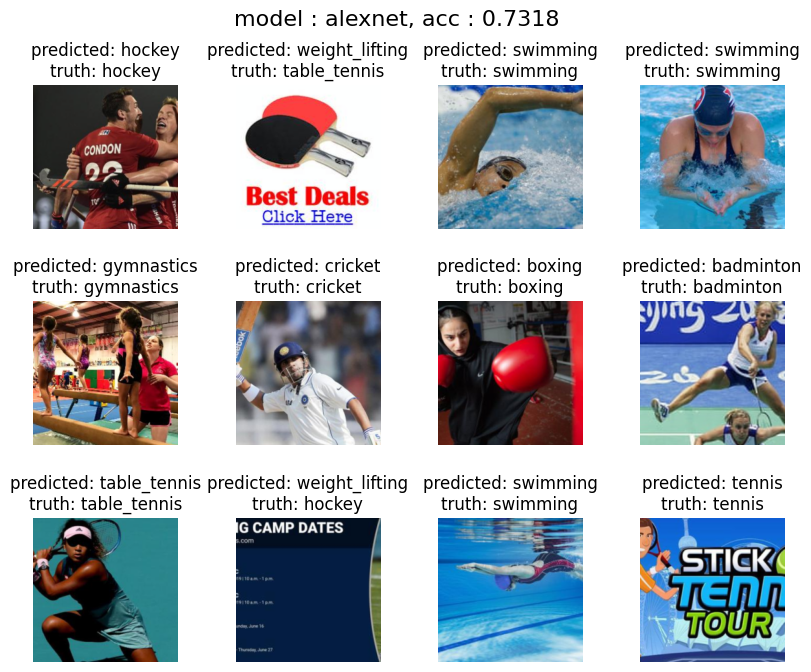

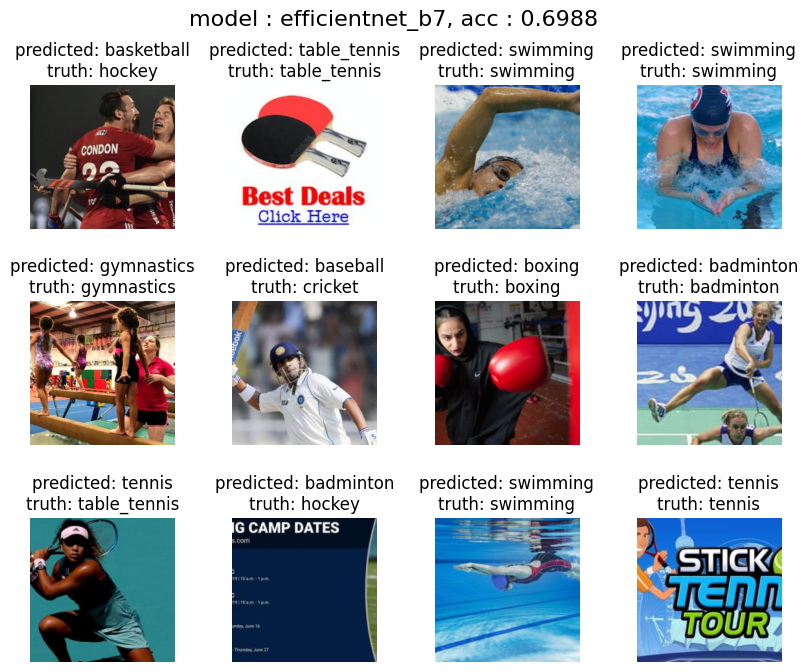

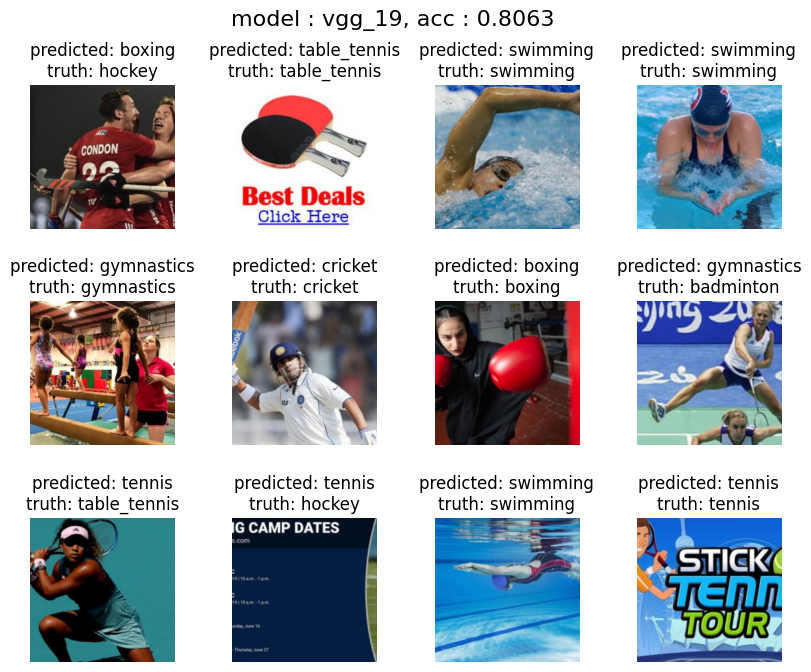

In [28]:
idx = np.random.choice(range(X.shape[0]), replace=False, size=12)
for model_name, opti_model in loaded_models.items():
    visualize_model(X[idx], y[idx], opti_model, num_images=12, suptitle=f'model : {model_name}, acc : {round(models_best_accuracy[model_name],4)}')